<a href="https://colab.research.google.com/github/sankarramamurthy/Data-Analytics/blob/main/Pepsi_Sales_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pepsi Sales Analytics
This is a sample case study to analyse the in-store sales of Pepsi beverage. The methodology adopted for this is Linear Regression. The dataset is uploaded to the Notebook from a CSV file

# 1) Setup and Installs

In [ ]:
# Install essential libraries (quiet). Keep dependencies minimal and stable.
!pip -q install xgboost shap ucimlrepo

#Import the Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import warnings
import warnings
warnings.filterwarnings('ignore')

#Import the required methods from sklearn module
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
import shap

print("Setup complete.")

Setup complete.


# 2) Load the data
The dataset is loaded from a CSV file, which needs to be provided as a user input when prompted

In [ ]:
df = None

# ---- A) Try Upload (works in Google Colab) ----
try:
    from google.colab import files  # Will fail outside Colab
    print("Colab detected. Please upload the CSV file")
    uploaded = files.upload()  # Prompts file chooser
    if uploaded:
        import io
        fname = next(iter(uploaded.keys()))
        # Robust encodings for degree symbols etc.
        for enc in ['ISO-8859-1', 'cp1252', 'latin1', 'utf-8']:
            try:
                df = pd.read_csv(io.BytesIO(uploaded[fname]), encoding=enc)
                print(f"Loaded '{fname}' with encoding={enc}. Shape:", df.shape)
                break
            except Exception as e:
                last_err = e
        if df is None:
            raise last_err
except Exception as e:
    print("Upload not used or failed; will try existing df. Reason:", e)


# ---- B) If df is still None, check if user already defined 'df' earlier ----
try:
    assert df is not None
except AssertionError:
    raise RuntimeError("No data loaded. Please upload a CSV or ensure 'df' is defined.")

df.head()

Colab detected. Please upload the CSV file


Saving Pepsi_InSales_CSV.csv to Pepsi_InSales_CSV.csv
Loaded 'Pepsi_InSales_CSV.csv' with encoding=ISO-8859-1. Shape: (300, 5)


,ï»¿StoreSite,lnSales,Age,Ad,Price
0,1,-0.83,0.57,2,0.60
1,2,5.03,0.68,6,0.43
2,3,3.17,0.47,4,0.48
3,4,1.71,0.79,3,0.60
4,5,0.90,0.49,2,0.58


# 3) Exploratory Data Analytics (EDA)

In [ ]:
df.shape

(300, 5)

In [ ]:
print(df.corr())

              ï»¿StoreSite   lnSales       Age        Ad     Price
ï»¿StoreSite      1.000000  0.044742  0.009104  0.070915 -0.147871
lnSales           0.044742  1.000000  0.022091  0.950267 -0.031117
Age               0.009104  0.022091  1.000000  0.075130 -0.047750
Ad                0.070915  0.950267  0.075130  1.000000  0.028099
Price            -0.147871 -0.031117 -0.047750  0.028099  1.000000


In [ ]:
print(df.describe())

       ï»¿StoreSite    lnSales         Age          Ad       Price
count    300.000000  300.00000  300.000000  300.000000  300.000000
mean     150.500000    5.14570    0.611433    6.226667    0.443667
std       86.746758    3.49358    0.173395    3.107111    0.100006
min        1.000000   -2.69000    0.300000    1.000000    0.270000
25%       75.750000    2.37500    0.477500    3.000000    0.360000
50%      150.500000    5.40500    0.610000    6.000000    0.440000
75%      225.250000    8.08000    0.770000    9.000000    0.532500
max      300.000000   12.73000    0.900000   11.000000    0.600000


<Axes: xlabel='lnSales', ylabel='Density'>

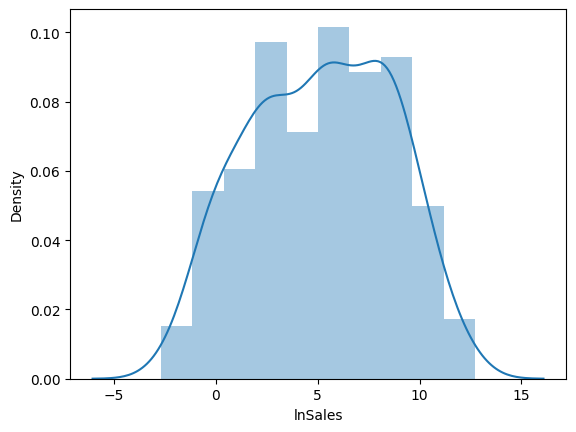

In [ ]:
sns.distplot(df['lnSales'])

**Conclusion** - The InSales data is normally distributed

Relationship of InSales with the other variables

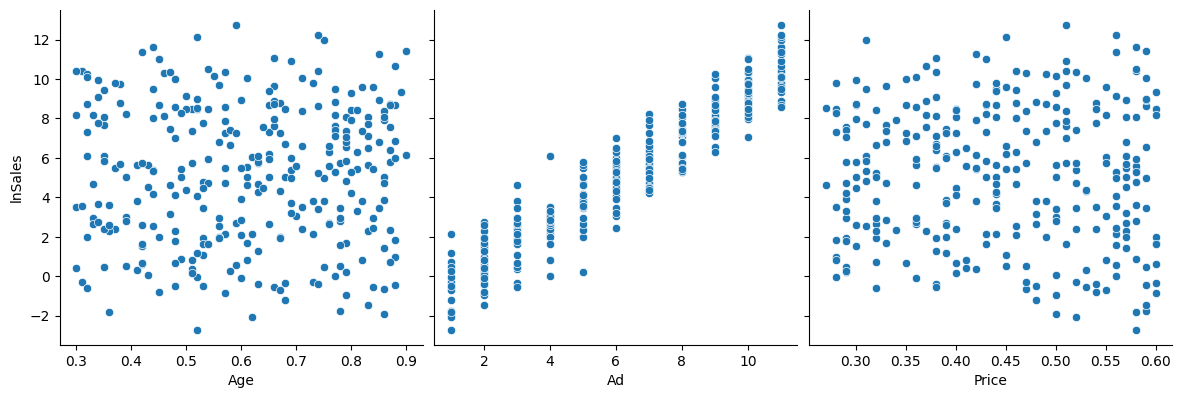

In [ ]:
sns.pairplot(df, x_vars=['Age', 'Ad', 'Price'], y_vars='lnSales', height=4, aspect=1, kind='scatter')
plt.show()

The correlation matrix between the variables, represented as a Heatmap

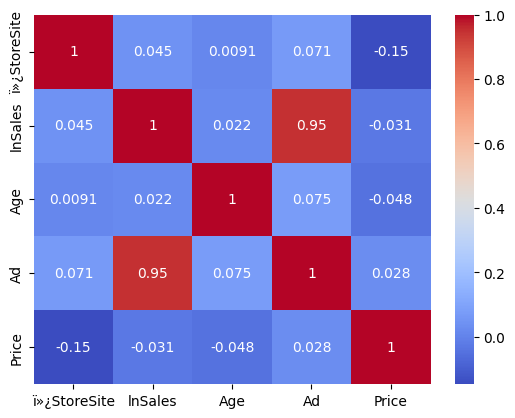

In [ ]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.show()

# 4) Initialise Train and Test

X is the list of Independent variables i.e. Age, Ad, Price
y is the Dependent variable i.e. lnSales
The Equation for multiple linear regression is:
y = X1 * Coeff1 + X2 * Coeff2 + X3 * Coeff3 + E

In [ ]:
#Setting the value for X and Y
X = df[['Age', 'Ad', 'Price']]
y = df['lnSales']

Splitting the dataset into training and testing sets. Based on the best practice, 70% of the data is kept under the training dataset and remaining 30% under the test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [ ]:
y_train.shape

(210,)

In [ ]:
y_test.shape

(90,)

# 5) Baseline: Multiple Linear Regression

In [ ]:
reg_Model = LinearRegression()

#Fitting the Multiple Linear Regression Model
reg_Model = LinearRegression().fit(X_train, y_train)

#Print the Intercept
print('Intercept: ', reg_Model.intercept_)

#Pair the feature names with the coefficients
list(zip(X, reg_Model.coef_))

Intercept:  0.02362522944771772


[('Age', np.float64(-1.1981415947772562)),
 ('Ad', np.float64(1.098664755497523)),
 ('Price', np.float64(-2.309318799844273))]

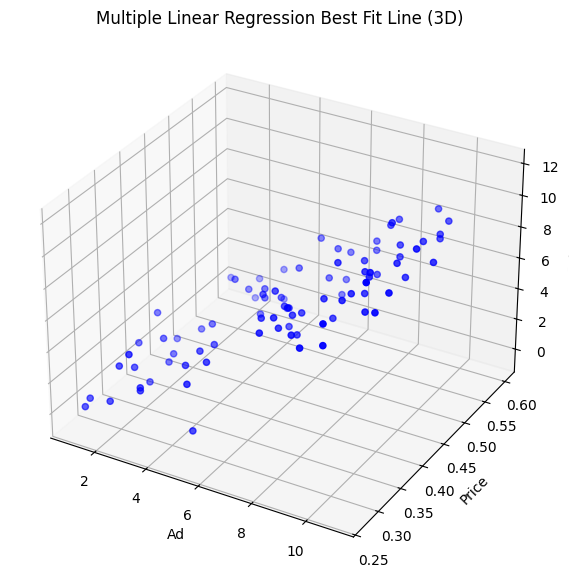

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['Ad'], X_test['Price'],
           y_test, color='blue', label='Actual Data')

x1_range = np.linspace(X_test['Age'].min(), X_test['Age'].max(), 100)
x2_range = np.linspace(X_test['Ad'].min(), X_test['Ad'].max(), 100)
x3_range = np.linspace(X_test['Price'].min(), X_test['Price'].max(), 100)
x1, x2, x3 = np.meshgrid(x1_range, x2_range, x3_range)

z = reg_Model.predict(np.c_[x1.ravel(), x2.ravel(), x3.ravel()]).reshape(x2.shape)

#ax.plot_surface(x2, x3, z, color='red', alpha=0.5, rstride=100, cstride=100)

ax.set_xlabel('Ad')
ax.set_ylabel('Price')
ax.set_zlabel('Sales')
ax.set_title('Multiple Linear Regression Best Fit Line (3D)')

plt.show()

# 6) Predictions

In [ ]:
#Predicting the Test and Train set result
y_pred= reg_Model.predict(X_test)
x_pred= reg_Model.predict(X_train)

In [ ]:
print("Prediction for test set: {}".format(y_pred))

Prediction for test set: [ 0.68617501 -0.14735291  4.73443621  4.31595629  2.79634963  0.64936112
  0.66829968 -0.74536046  3.19154276 10.12060329  7.90298312  3.91723793
  0.72801316  9.2332558   9.44979093 -0.19590795  5.85165233  2.07480908
 10.49444252 10.89417746  9.21538048  7.14743121  1.28944709  4.67433553
  5.75927958 10.55608888  8.13980891  8.39663651 -1.1388143   8.89710011
  7.02916274  7.9489759   8.13980891  3.66910677  6.28037438  9.48902016
 -0.24233459 10.62730133  1.26809319  9.15218842  7.81128641 -0.40137798
  5.54815591  4.84468429  7.10433621  0.67071502  1.11929193  2.37700007
  2.41729254  4.01965921  6.02200109  0.91469155  4.80787039  9.11798346
  3.01443045  5.92875869  0.96329326 -0.99349162  4.64119381  7.20627504
  6.85726829  6.23592729  0.33214399  8.19952239  4.58891993  4.47258435
  2.48396317  9.30794683  9.76459272  6.50217403  2.93732409  7.70345367
  5.59608158  1.56067144  3.79549088  8.48292175  7.12414442  4.66496305
  1.09682813  3.7573249   

In [ ]:
#Actual value and the predicted value
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff

,Actual value,Predicted value
222,0.17,0.686175
139,-0.03,-0.147353
216,5.74,4.734436
201,2.47,4.315956
249,2.81,2.796350
...,...,...
229,4.47,6.155536
29,5.05,3.769982
205,0.24,3.900715
234,4.64,1.965237


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)

Mean Absolute Error: 0.8324255829525964
Mean Square Error: 1.1893785566356005
Root Mean Square Error: 1.0905863361676602
